<a href="https://colab.research.google.com/github/rizaho/ml_for_financial_analysis/blob/main/201_3_ARIMA_SARIMA_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pmdarima installation

In [1]:
!pip install pmdarima
!pip install numpy==1.26.4 # for pmdarima compatibility error

In [2]:
from pmdarima import auto_arima, ARIMA, model_selection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from google.colab import drive
import seaborn as sns
%matplotlib inline
from copy import copy
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import math
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # auto correlation, partial auto-correlation
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller

# runtime settings
import sys
#np.set_printoptions(threshold=sys.maxsize)

# Utils

## model_assesment(train, test, predictions, chart_title = None)

In [20]:
# Function tha asseses the model and visualizes the train, test and forcast
def model_assesment(train, test, predictions, chart_title = None):
  # Set the size of the plot 10 by 4
  plt.figure(figsize = (10, 4))

  # Plot the train, test and forecast data
  plt.plot(train, label = "Train")
  plt.plot(test, label = "Test")
  plt.plot(predictions, label = "Forecast")
  plt.title(chart_title)
  plt.legend()
  plt.show()
  # Calculate the RMSE, MAE, and MAPE
  rsme = root_mean_squared_error(test, predictions)
  mae = mean_absolute_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  print(f"RMSE: {rsme:.2f}")
  print(f"MAE: {mae:.2f}")
  print(f"MAPE: {100 * mape:.2f} %")

In [3]:
# read data from google drive
drive.mount('/content/drive')
DATA_ROOT_PATH = "Python-Time-Series-Forecasting"
# /content/drive/MyDrive/Colab Notebooks/Python-Time-Series-Forecasting/ARIMA, SARIMA and SARIMAX
DATA_SUB_INTRO = "ARIMA, SARIMA and SARIMAX"
DRIVE_DATASET_PATH = "/content/drive/My Drive/Colab Notebooks/" + DATA_ROOT_PATH + "/" + DATA_SUB_INTRO + "/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# read data

In [4]:
df = pd.read_csv(DRIVE_DATASET_PATH + "daily_revenue.csv",
                 index_col = "date",
                 parse_dates=True,
                 dayfirst = True)
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   revenue        1795 non-null   object
 1   discount_rate  1795 non-null   object
 2   coupon_rate    1795 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


# Data modification

In [6]:
# revenue, discount_rate, and coupon_rate are all objects. So convert them into float.
# Convert revenue into float
df['revenue'] = df['revenue'].str.replace(',','').astype(float)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        1795 non-null   float64
 1   discount_rate  1795 non-null   object 
 2   coupon_rate    1795 non-null   object 
dtypes: float64(1), object(2)
memory usage: 56.1+ KB


In [7]:
# update frequency
df = df.asfreq("D") # frequency is [D]aily.
df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq='D')

In [8]:
# change column name revenue to y
df.rename(columns={'revenue': 'y'}, inplace=True)
df

,y,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27%,1.09%
2018-01-02,8922076.0,30.87%,1.08%
2018-01-03,8446101.0,28.11%,1.01%
2018-01-04,7785798.0,27.32%,0.96%
2018-01-05,6375303.0,25.70%,0.90%
...,...,...,...
2022-11-26,26934947.0,30.41%,0.38%
2022-11-27,31890868.0,29.75%,0.35%
2022-11-28,32100918.0,25.27%,8.93%


# Explotary Data Analysis

## Plot - Daily Revenues

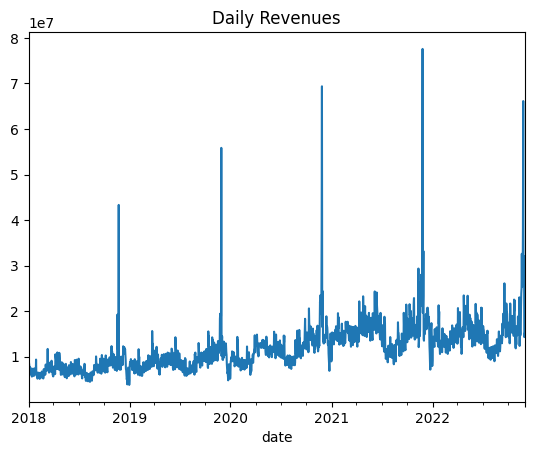

In [9]:
df["y"].plot(title = "Daily Revenues")
plt.show()

## Plot - Montly Revenues

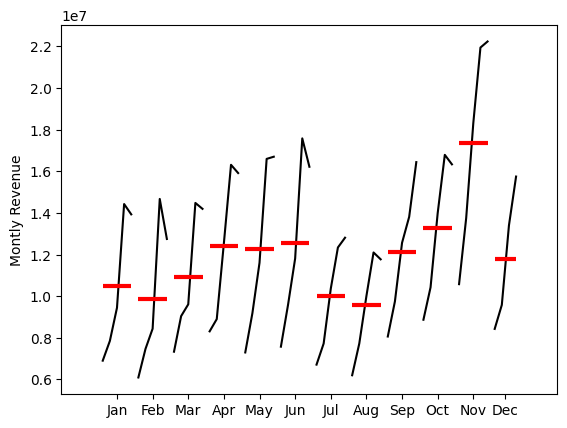

In [10]:
month_plot(df["y"].resample("ME").mean(),
           ylabel="Montly Revenue")
plt.show()

## Plot - Quarterly Revenues

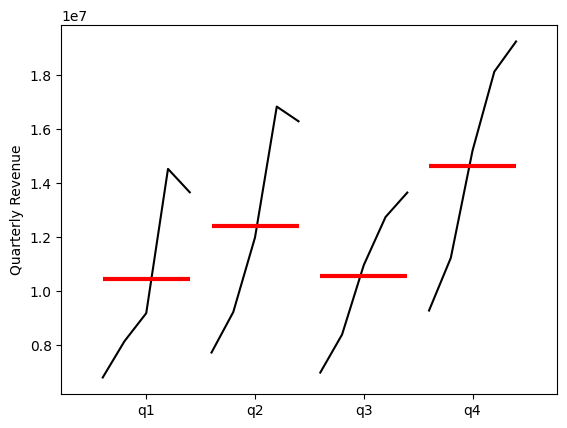

In [11]:
# Plot quarterly revenues
quarter_plot(df["y"].resample("QE").mean(),
             ylabel="Quarterly Revenue")
plt.show()



# Seasonal Decomposition

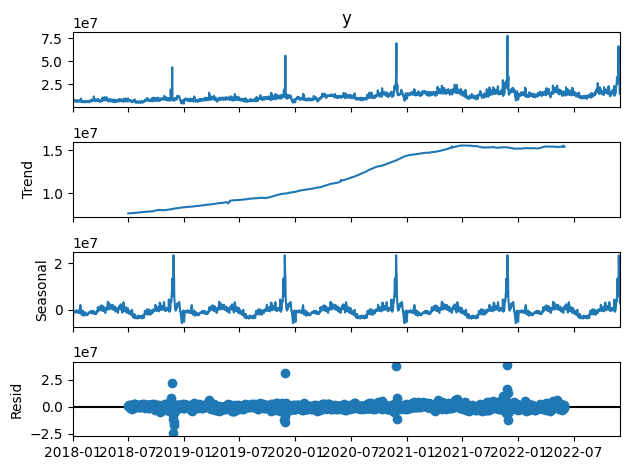

In [12]:
# Plot seasonal decomposition
seasonal_decomposition = seasonal_decompose(
    df["y"],
    model="additive",
    period = 365)
fig = seasonal_decomposition.plot()
plt.show()

# Auto Correlation

## Auto Correlation (ACF)

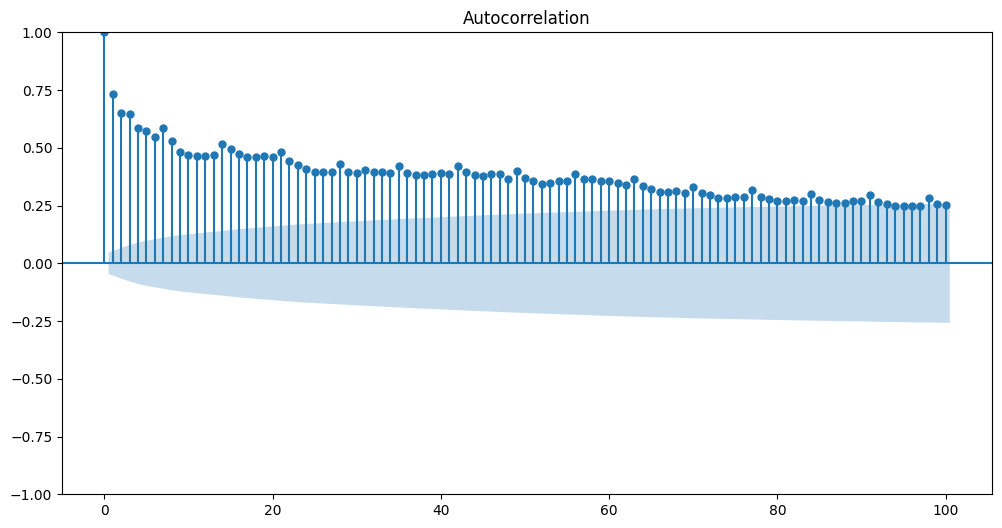

In [13]:
# Plot auto correlation (ACF)
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df["y"], lags=100, ax = ax)
plt.show()

## Partial Auto Correlation (PACF)

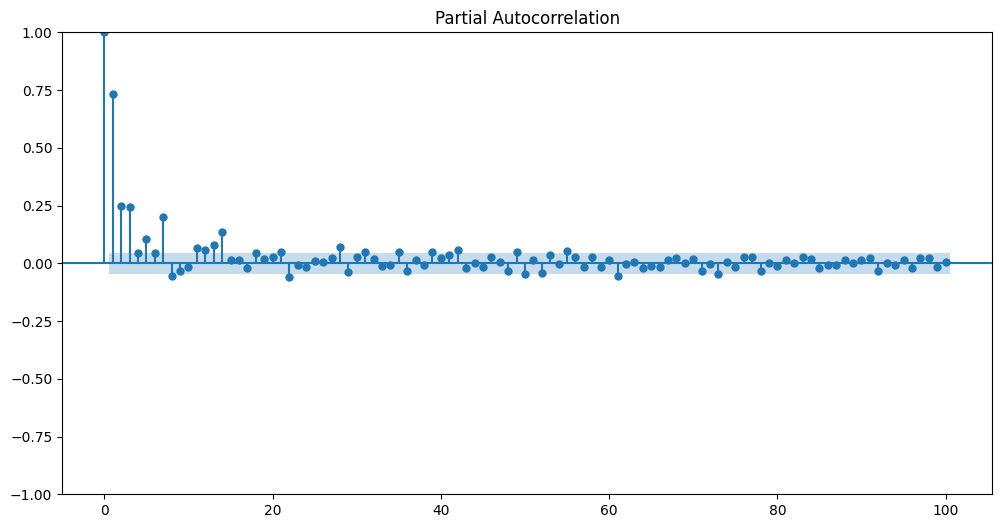

In [14]:
# Plot partial auto correlation (PACF)
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(df["y"], lags=100, ax = ax)
plt.show()

# ARIMA (AutoRegressive Integrated Moving Average)

It is a popular time series forecasting model that combines three key components:
* AutoRegressive (AR): Uses past values (lags) of the time series to predict future values.
* Integrated (I): Differencing the data to make it stationary (i.e., removing trends or seasonality).
* Moving Average (MA): Uses past forecast errors to improve predictions.

The ARIMA model is often represented as ARIMA(p, d, q), where:

* p = number of autoregressive (AR) terms
* d = number of differencing (I) steps to make the series stationary
* q = number of moving average (MA) terms

Ref: https://chatgpt.com/share/67d9436b-6738-8008-9dd1-88ffa401533e

## AutoRegressive (AR):
* Uses past values (lags) of the time series to predict future values.
* AR is super powerful in such time series where patterns and trends are important.


## Integrated (I)
* Stationary time series has stable patterns which make predictions easier.
* Differencing: Smooths out the up&downs in the time series.

### Stationarity (Adfuller Test)

In [15]:
adfuller_test_result = adfuller(df["y"])
print("ADF Statistic: %f" % adfuller_test_result[0])
print("p-value: %f" % adfuller_test_result[1])

# interpreting the adfuller test result
if (adfuller_test_result[1] < 0.05):
    print("The time series is stationary")
else:
    print("The time series is not stationary")

ADF Statistic: -2.558400
p-value: 0.101904
The time series is not stationary


### Differencing (to remove the up&downs in time series)

(After Differencing) The time series is stationary


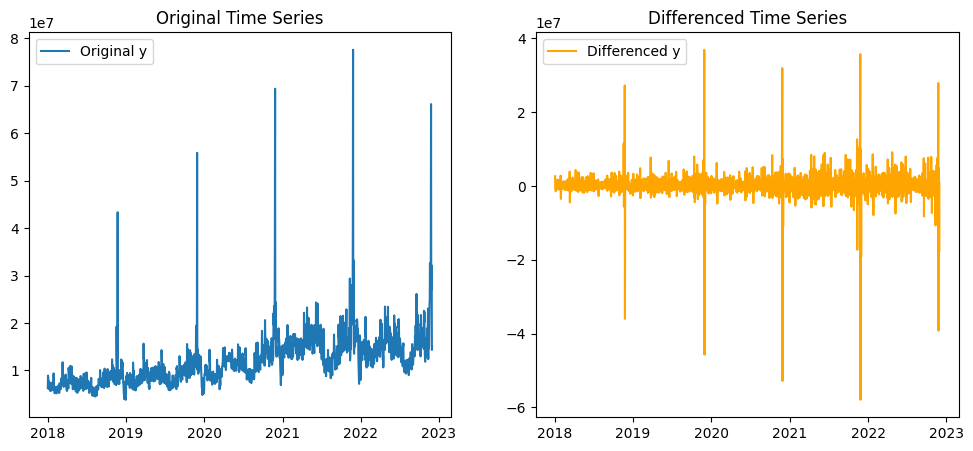

In [16]:
# chatgpt: write code to make df.y stationary and plot the df.y and differenced df.y

# Original series plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(df.y, label='Original y')
plt.title('Original Time Series')
plt.legend()

# Differencing to make it stationary
df['y_diff'] = df.y.diff().dropna()

adfuller_test_result_after_diff = adfuller(df['y_diff'].dropna())

# interpreting the adfuller test result
if (adfuller_test_result_after_diff[1] < 0.05):
    print("(After Differencing) The time series is stationary")
else:
    print("(After Differencing) The time series is not stationary")

# Differenced series plot
plt.subplot(1, 2, 2)
plt.plot(df['y_diff'], label='Differenced y', color='orange')
plt.title('Differenced Time Series')
plt.legend()

plt.show()

## Moving Average (MA)

* Examines previous errors

# Modeling with ARIMA

## Train-Test split

In [35]:
test_days = 30
train, test = df.iloc[:-test_days, :], df.iloc[-test_days:, :]
test

,y,discount_rate,coupon_rate,y_diff
date,,,,
2022-11-01,16703680.0,23.85,1.50,4014654.0
2022-11-02,15827022.0,20.76,0.94,-876658.0
2022-11-03,16154319.0,21.85,0.92,327297.0
2022-11-04,14707212.0,20.17,0.88,-1447107.0
2022-11-05,14877530.0,17.85,0.41,170318.0
2022-11-06,18835528.0,16.40,0.31,3957998.0
2022-11-07,16094516.0,17.11,0.30,-2741012.0
2022-11-08,15589508.0,16.64,0.29,-505008.0
2022-11-09,16608320.0,18.72,0.74,1018812.0


In [18]:
# Using pmdarima for the arima model and the best parameters
# arima decides the parameters itself.
model = auto_arima(
    train["y"],
    seasonal = False)

model.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -28817.267
Date:                Tue, 18 Mar 2025   AIC                          57650.535
Time:                        11:39:32   BIC                          57694.337
Sample:                    01-01-2018   HQIC                         57666.720
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.120     -3.449      0.001      -0.649      -0.179
ar.L2          0.3017      0.053      5.671      0.000       0.197       0.406
ar.L3          0.1570      0.028      5.705      0.000       0.103       0.211
ar.L4          0.0679      0.029      2.365      0.018       0.012       0.124
ar.L5          0.0466      0.024      1.937      0.053      -0.001       0.094
ma.L1         -0.1598      0.118     -1.354      0.176      -0.391       0.071
ma.L2         -0.7423      0.108     -6.872      0.000      -0.954      -0.531
sigma2      9.084e+12   1.86e-14   4.88e+26      0.000    9.08e+12    9.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            580903.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             5.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+42. Standard errors may be unstable.
"""

## predictions

In [19]:
predictions_arima = model.predict(n_periods=len(test))
predictions_arima
# getting similar values are expected (may be check the reason)!

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0
2022-11-01,1.445299e+07
2022-11-02,1.474103e+07
2022-11-03,1.503283e+07
2022-11-04,1.527520e+07
2022-11-05,1.534078e+07
2022-11-06,1.553442e+07
2022-11-07,1.554542e+07
2022-11-08,1.563967e+07
2022-11-09,1.565016e+07
2022-11-10,1.569221e+07


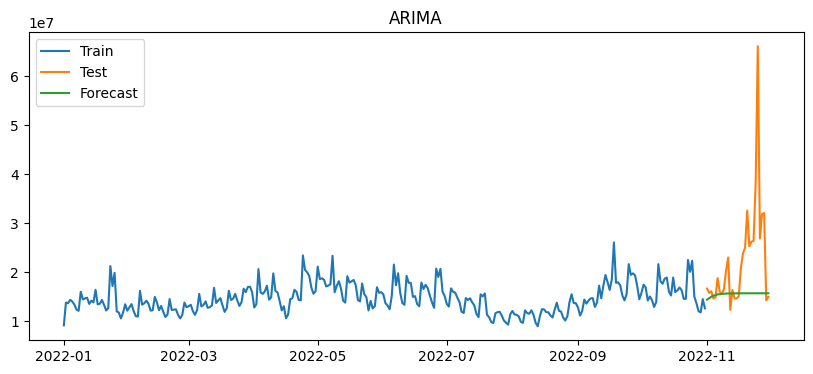

RMSE: 12366038.29
MAE: 7267306.02
MAPE: 24.15 %


In [26]:
model_assesment(train["y"]["2022" :], test["y"], predictions_arima, "ARIMA")

# We completely missed the spike. ARIMA is not doing well here.
# Because our time series has deeply seasonal data

# SARIMA (Seasonal AutoRegressive Integrated Moving Average)

It is an extension of the ARIMA model that accounts for seasonality in time series data.

SARIMA(p,d,q)×(P,D,Q,s)

where:

* (p, d, q): Standard ARIMA terms
  * p = Number of autoregressive (AR) terms
  * d = Number of differencing (I) terms
  * q = Number of moving average (MA) terms
* (P, D, Q, s): Seasonal components
  * P = Seasonal autoregressive terms
  * D = Seasonal differencing terms
  * Q = Seasonal moving average terms
  * s = Seasonal period (e.g., 12 for monthly data, 4 for quarterly data)

# Modeling with SARIMA


In [27]:
# Using pmdarima for the arima model and the best parameters
# arima decides the parameters itself.
# train-test split was already done on the ARIMA section.
model_sarima = auto_arima(train["y"],
                          m = 7)

model_sarima.summary()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28762.051
Date:                           Tue, 18 Mar 2025   AIC                          57546.103
Time:                                   12:55:36   BIC                          57606.331
Sample:                               01-01-2018   HQIC                         57568.358
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.007e+04   4683.063      2.150      0.032     889.683    1.92e+04
ar.L1         -0.3476      0.072     -4.798      0.000      -0.490      -0.206
ar.L2          0.1856      0.032      5.722      0.000       0.122       0.249
ar.L3          0.1034      0.016      6.523      0.000       0.072       0.135
ma.L1         -0.1958      0.074     -2.656      0.008      -0.340      -0.051
ma.L2         -0.5684      0.060     -9.401      0.000      -0.687      -0.450
ar.S.L7        0.0805      0.181      0.445      0.656      -0.274       0.435
ar.S.L14       0.8712      0.172      5.071      0.000       0.534       1.208
ma.S.L7       -0.0035      0.176     -0.020      0.984      -0.349       0.342
ma.S.L14      -0.8322      0.157     -5.310      0.000      -1.139      -0.525
sigma2      9.294e+12      0.000   8.85e+16      0.000    9.29e+12    9.29e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            848628.48
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                             5.24
Prob(H) (two-sided):                  0.00   Kurtosis:                       109.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+31. Standard errors may be unstable.
"""

In [28]:
predictions_sarima = model_sarima.predict(n_periods=len(test))
predictions_sarima


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0
2022-11-01,1.513413e+07
2022-11-02,1.504531e+07
2022-11-03,1.464456e+07
2022-11-04,1.382187e+07
2022-11-05,1.398001e+07
2022-11-06,1.697840e+07
2022-11-07,1.583295e+07
2022-11-08,1.605198e+07
2022-11-09,1.575788e+07
2022-11-10,1.523578e+07


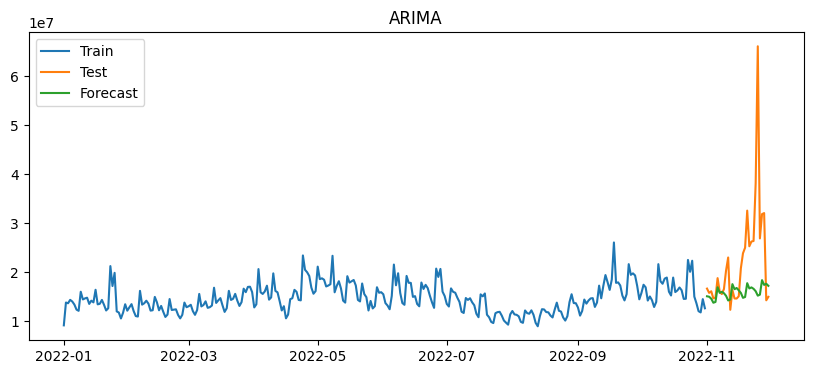

RMSE: 12152429.39
MAE: 7210576.21
MAPE: 24.54 %


In [29]:
model_assesment(train["y"]["2022" :], test["y"], predictions_sarima, "ARIMA")

# below, still we are missing the spike but we have some seasonality forecasts.

# SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables)

Ref: https://chatgpt.com/share/67d9436b-6738-8008-9dd1-88ffa401533e

It is an extension of the SARIMA model that includes exogenous (external) variables (X), which can help improve forecasts by incorporating additional information.

SARIMAX Components:
* (p, d, q): Standard ARIMA terms
  * p = Number of autoregressive (AR) terms
  * d = Number of differencing (I) terms
  * q = Number of moving average (MA) terms
* (P, D, Q, s): Seasonal components
  * P = Seasonal autoregressive terms
  * D = Seasonal differencing terms
  * Q = Seasonal moving average terms
  * s = Seasonal period (e.g., 12 for monthly data, 4 for quarterly data)

* Exogenous Variables (X): Additional independent variables that influence the dependent variable (e.g., economic indicators, weather, promotions, etc.).

## Transform the regressors into floats

In [30]:
df.columns

Index(['y', 'discount_rate', 'coupon_rate', 'y_diff'], dtype='object')

In [37]:
df.head()

,y,discount_rate,coupon_rate,y_diff
date,,,,
2018-01-01,6270839.0,34.27,1.09,NaN
2018-01-02,8922076.0,30.87,1.08,2651237.0
2018-01-03,8446101.0,28.11,1.01,-475975.0
2018-01-04,7785798.0,27.32,0.96,-660303.0
2018-01-05,6375303.0,25.70,0.90,-1410495.0


In [36]:
# remove , character from discount_rate column
df['discount_rate'] = df['discount_rate'].str.replace('%','').astype(float)
df['coupon_rate'] = df['coupon_rate'].str.replace('%','').astype(float)
df.info()

AttributeError: Can only use .str accessor with string values!

## Train-test split for the regressors in SARIMAX

We are getting the other variables also.

*   List item
*   List item



In [39]:
test_days = 30
exog_train, exog_test = df.iloc[:-test_days, 1:3], df.iloc[-test_days:, 1:3]
test

,y,discount_rate,coupon_rate,y_diff
date,,,,
2022-11-01,16703680.0,23.85,1.50,4014654.0
2022-11-02,15827022.0,20.76,0.94,-876658.0
2022-11-03,16154319.0,21.85,0.92,327297.0
2022-11-04,14707212.0,20.17,0.88,-1447107.0
2022-11-05,14877530.0,17.85,0.41,170318.0
2022-11-06,18835528.0,16.40,0.31,3957998.0
2022-11-07,16094516.0,17.11,0.30,-2741012.0
2022-11-08,15589508.0,16.64,0.29,-505008.0
2022-11-09,16608320.0,18.72,0.74,1018812.0


In [40]:
model_sarimax = auto_arima(train["y"], m = 7, X = exog_train)
model_sarimax.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28613.022
Date:                           Tue, 18 Mar 2025   AIC                          57250.045
Time:                                   13:31:37   BIC                          57315.749
Sample:                               01-01-2018   HQIC                         57274.324
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1.641e+04   7880.847      2.082      0.037     964.544    3.19e+04
discount_rate   4.03e+05   2.35e+04     17.146      0.000    3.57e+05    4.49e+05
coupon_rate    9.229e+05   6.09e+04     15.156      0.000    8.04e+05    1.04e+06
ar.L1            -0.6527      0.155     -4.198      0.000      -0.957      -0.348
ar.L2             0.1827      0.049      3.766      0.000       0.088       0.278
ma.L1             0.1067      0.155      0.690      0.490      -0.197       0.410
ma.L2            -0.6922      0.124     -5.567      0.000      -0.936      -0.449
ar.S.L7           0.0524      0.187      0.280      0.780      -0.315       0.419
ar.S.L14          0.8999      0.178      5.062      0.000       0.551       1.248
ma.S.L7           0.0182      0.183      0.099      0.921      -0.340       0.376
ma.S.L14         -0.8501      0.161     -5.286      0.000      -1.165      -0.535
sigma2         7.655e+12      0.016   4.82e+14      0.000    7.65e+12    7.65e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1075250.80
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             5.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       123.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.85e+29. Standard errors may be unstable.
"""

# predictions for SARIMAX

In [42]:
predictions_sarimax = model_sarimax.predict(n_periods=len(test), X = exog_test)
predictions_sarimax


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0
2022-11-01,1.675203e+07
2022-11-02,1.494534e+07
2022-11-03,1.488390e+07
2022-11-04,1.296350e+07
2022-11-05,1.205396e+07
2022-11-06,1.394979e+07
2022-11-07,1.341718e+07
2022-11-08,1.328240e+07
2022-11-09,1.441167e+07
2022-11-10,2.077564e+07


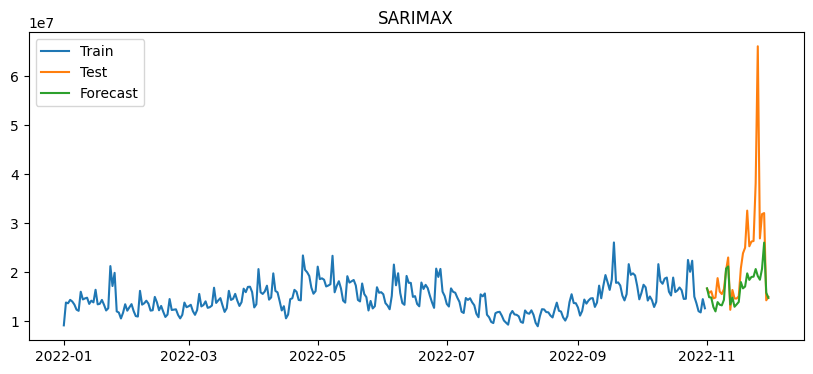

RMSE: 10394553.04
MAE: 5716506.24
MAPE: 19.36 %


In [44]:
model_assesment(train["y"]["2022" :], test["y"], predictions_sarimax, "SARIMAX")